In [1]:
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import re
import glob
from tqdm.auto import tqdm
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    SeparableConv1D,
    BatchNormalization,
    MaxPooling1D,
    GlobalAveragePooling1D,
    Bidirectional,
    LSTM,
    Dense,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import Counter

/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


a faire : retrouver model qui a à peu près marché
essayer de convolve la data

## Data loading and preparation

In [2]:
# just learned that model can memorize specific locations on plate to classify, not good !
# solution : reset first frame as (0,0) and normalize by orientation ( so the direction of first movement is the same)
import matplotlib.pyplot as plt

def plot_trajectory(df, x_col="X", y_col="Y", title="Trajectory"):
    """
    Plot a 2D trajectory given a DataFrame with X/Y columns.
    """
    plt.figure(figsize=(6, 6))
    
    plt.plot(df[x_col], df[y_col], marker='o', markersize=2, linewidth=1)
    
    # Mark start and end
    plt.scatter(df[x_col].iloc[0], df[y_col].iloc[0], color='green', s=50, label="Start")
    plt.scatter(df[x_col].iloc[-1], df[y_col].iloc[-1], color='red', s=50, label="End")
    
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.axis('equal')  # important for not distorting shape
    plt.grid(True)
    plt.show()



def recenter_coordinates(df, x_col="X", y_col="Y"):
    """
    Center coordinates so that the first frame is at (0,0).
    Returns a copy of the df with new columns: X_centered, Y_centered.
    """
    df = df.copy()
    x0, y0 = df[x_col].iloc[0], df[y_col].iloc[0]
    df["X_centered"] = df[x_col] - x0
    df["Y_centered"] = df[y_col] - y0
    return df

def rotate_to_initial_heading(df, x_col="X_centered", y_col="Y_centered"):
    """
    Rotate the centered coordinates so the initial movement direction is aligned with angle 0.
    Returns df with new columns: X_rot, Y_rot.
    """

    df = df.copy()

    # Compute initial displacement (need at least 2 frames)
    dx = df[x_col].iloc[1] - df[x_col].iloc[0]
    dy = df[y_col].iloc[1] - df[y_col].iloc[0]

    # Angle of initial heading
    theta = np.arctan2(dy, dx)

    # Rotation matrix to align with 0 radians
    c, s = np.cos(-theta), np.sin(-theta)
    R = np.array([[c, -s],
                  [s,  c]])

    # Apply rotation
    coords = df[[x_col, y_col]].values.T  # shape (2, timesteps)
    rotated = R @ coords                   # matrix multiplication

    df["X_rot"] = rotated[0]
    df["Y_rot"] = rotated[1]

    return df



In [3]:
#loading data A GARDER POUR LOADING DATA FROM FOLDER

SEGMENTS_DIR = "preprocessed_data/segments"
FULL_DIR = "preprocessed_data/full"
DATA_DIR = os.path.join(os.getcwd(), "TERBINAFINE")
LIFESPAN_FILE = os.path.join(DATA_DIR, "lifespan_summary.csv")
SEGMENT_LENGTH = 900 
FEATURE_COLS = ['dx', 'dy', 'Speed', 'turning_angle'] 
#FEATURE_COLS = ['X', 'Y'] 
KEEP_SEGMENTS_WITH_DEATH_INSIDE = True

print(len(os.listdir(SEGMENTS_DIR)), "files found")
print(os.listdir(SEGMENTS_DIR)[:5])

8150 files found
['coordinates_highestspeed_20250205_9_3_with_time_speed-fragment4.0-preprocessed.csv', 'coordinates_highestspeed_20240924_11_1_with_time_speed-fragment33.0-preprocessed.csv', 'coordinates_highestspeed_20240924_12_6_with_time_speed-fragment19.0-preprocessed.csv', 'coordinates_highestspeed_20250415_9_1_with_time_speed-fragment56.0-preprocessed.csv', 'coordinates_highestspeed_20250205_12_5_with_time_speed-fragment5.0-preprocessed.csv']


In [4]:
all_segment_dfs = []
seg_files = sorted(os.listdir(SEGMENTS_DIR))

for fname in tqdm(seg_files):
    if not fname.endswith(".csv"):
        continue

    df = pd.read_csv(os.path.join(SEGMENTS_DIR, fname))
    all_segment_dfs.append(df)

centered_dfs = [recenter_coordinates(df) for df in all_segment_dfs]
rotated_dfs = [rotate_to_initial_heading(df) for df in centered_dfs]

# adding displacement to represent pure movement
for df in rotated_dfs:
    df["dx"] = df["X_rot"].diff().fillna(0)
    df["dy"] = df["Y_rot"].diff().fillna(0)

100%|██████████| 8150/8150 [00:16<00:00, 492.47it/s]


In [5]:
#prepare preprocessed data for model
X_seg_list = []
y_seg_list = []
worm_ids =[]

for df in rotated_dfs:
     # get condition label
    label = df["condition"].iloc[0]
    worm_id = df["worm_id"].iloc[0]

    # extract features
    seg = df[FEATURE_COLS].values

    # --- handle variable length segments ---
    if len(seg) < SEGMENT_LENGTH:
        # pad with zeros
        pad_len = SEGMENT_LENGTH - len(seg)
        seg = np.pad(seg, ((0, pad_len), (0, 0)), mode="constant")
    else:
        # truncate
        seg = seg[:SEGMENT_LENGTH]

    X_seg_list.append(seg)
    y_seg_list.append(label)
    worm_ids.append(worm_id)

X_seg = np.array(X_seg_list)   # shape: (n_segments, TIMESTEPS, 4)
y_seg = np.array(y_seg_list)
worm_ids = np.array(worm_ids)

print("X shape:", X_seg.shape)
print("y shape:", y_seg.shape)
print("worm_ids shape:", worm_ids.shape)

X shape: (8150, 900, 4)
y shape: (8150,)
worm_ids shape: (8150,)


In [6]:
# label encoding

le = LabelEncoder()
y_seg_encoded = le.fit_transform(y_seg)

print("Original labels:", np.unique(y_seg))
print("Encoded labels:", np.unique(y_seg_encoded))
print("Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

#class is balanced ?
(unique, counts) = np.unique(y_seg_encoded, return_counts=True)
print(dict(zip(unique, counts)))

Original labels: ['control' 'terbinafine']
Encoded labels: [0 1]
Mapping: {'control': 0, 'terbinafine': 1}
{0: 4074, 1: 4076}


### Train/test split

In [7]:
#group segments by worm ids to prevent data leakage

unique_worms = np.unique(worm_ids)
print("Total worms:", len(unique_worms))

worm_to_label = {}

# compute one condition label per worm
for w in unique_worms:
    # find any segment for that worm
    idx = np.where(worm_ids == w)[0][0]
    worm_to_label[w] = y_seg_encoded[idx]

worm_labels = np.array([worm_to_label[w] for w in unique_worms])

# stratification 20% test
train_worms, test_worms = train_test_split(
    unique_worms,
    test_size=0.2,
    random_state=42,
    stratify=worm_labels
)

# split again for validation inside model
worm_labels_for_train = np.array([worm_to_label[w] for w in train_worms])

train_worms_final, val_worms = train_test_split(
    train_worms,
    test_size=0.2,
    random_state=42,
    stratify=worm_labels_for_train
)


Total worms: 104


In [33]:
# build X and y train, validation and test

seg_train_mask = np.isin(worm_ids, train_worms_final)
seg_val_mask = np.isin(worm_ids, val_worms)
seg_test_mask  = np.isin(worm_ids, test_worms)

X_seg_train = X_seg[seg_train_mask]
X_seg_val = X_seg[seg_val_mask]
X_seg_test  = X_seg[seg_test_mask]

y_seg_train = y_seg_encoded[seg_train_mask]
y_seg_val = y_seg_encoded[seg_val_mask]
y_seg_test  = y_seg_encoded[seg_test_mask]

worm_ids_train = worm_ids[seg_train_mask]
worm_ids_val   = worm_ids[seg_val_mask]
worm_ids_test  = worm_ids[seg_test_mask]


print("Train shape:", X_seg_train.shape)
print("Val shape:", X_seg_val.shape)
print("Test shape:",  X_seg_test.shape)

# make sure no worm is in the two sets !!! triple cheeeck

print("Overlap train/val:", np.intersect1d(train_worms_final, val_worms))
print("Overlap train/test:", np.intersect1d(train_worms_final, test_worms))
print("Overlap val/test:", np.intersect1d(val_worms, test_worms))

Train shape: (5049, 900, 4)
Val shape: (1403, 900, 4)
Test shape: (1698, 900, 4)
Overlap train/val: []
Overlap train/test: []
Overlap val/test: []


In [9]:
# create smaller windows 

WINDOW = 300

def slice_into_windows(X, y, worm_ids, segment_ids, window=300):
    """
    Returns:
        X_new         -> (windows, window_size, features)
        y_new         -> labels per window
        worm_new      -> worm_id per window
        seg_new       -> segment_id per window
        win_index_new -> window index inside the segment
    """
    X_new = []
    y_new = []
    worm_new = []
    seg_new = []
    win_index_new = []

    for seg_array, label, wid, seg_id in zip(X, y, worm_ids, segment_ids):
        n = seg_array.shape[0]
        win_idx = 0
        for start in range(0, n, window):
            end = start + window
            if end <= n:
                X_new.append(seg_array[start:end])
                y_new.append(label)
                worm_new.append(wid)
                seg_new.append(seg_id)
                win_index_new.append(win_idx)
                win_idx += 1

    return (
        np.array(X_new),
        np.array(y_new),
        np.array(worm_new),
        np.array(seg_new),
        np.array(win_index_new)
    )

segment_ids = np.arange(len(X_seg))  # unique ID for each original segment

seg_train_ids = segment_ids[seg_train_mask]
seg_val_ids   = segment_ids[seg_val_mask]
seg_test_ids  = segment_ids[seg_test_mask]



X_train_win, y_train_win, worm_train_win, seg_train_win, win_idx_train = slice_into_windows(
    X_seg_train, y_seg_train, worm_ids_train, seg_train_ids, window=WINDOW
)

X_val_win, y_val_win, worm_val_win, seg_val_win, win_idx_val = slice_into_windows(
    X_seg_val, y_seg_val, worm_ids_val, seg_val_ids, window=WINDOW
)

X_test_win, y_test_win, worm_test_win, seg_test_win, win_idx_test = slice_into_windows(
    X_seg_test, y_seg_test, worm_ids_test, seg_test_ids, window=WINDOW
)


In [10]:
print("Train windows:", X_train_win.shape)
print("Val windows:  ", X_val_win.shape)
print("Test windows: ", X_test_win.shape)

print("Unique worms in train:", len(np.unique(worm_train_win)))
print("Unique worms in test:",  len(np.unique(worm_test_win)))

print("Train segments label counts:", np.bincount(y_seg_train))
print("Val   segments label counts:", np.bincount(y_seg_val))
print("Test  segments label counts:", np.bincount(y_seg_test))

print("Train windows label counts:", np.bincount(y_train_win))
print("Val   windows label counts:", np.bincount(y_val_win))
print("Test  windows label counts:", np.bincount(y_test_win))

Train windows: (15147, 300, 4)
Val windows:   (4209, 300, 4)
Test windows:  (5094, 300, 4)
Unique worms in train: 66
Unique worms in test: 21
Train segments label counts: [2557 2492]
Val   segments label counts: [641 762]
Test  segments label counts: [876 822]
Train windows label counts: [7671 7476]
Val   windows label counts: [1923 2286]
Test  windows label counts: [2628 2466]


In [11]:
# define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=5,
        min_lr=1e-6
    ),
   # ModelCheckpoint(
   #     "best_model.keras",
   #     monitor='val_loss',
   #     save_best_only=True
   # )
]

## CNN-LSTM hybrid model

### using windows

In [12]:


model_hyb300 = Sequential([
    # --- CNN Feature Extractor ---
    Conv1D(32, kernel_size=7, padding='same', activation='relu', input_shape=(300, 4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Dropout(0.3),

    # --- LSTM Temporal Reasoning ---
    LSTM(64, return_sequences=False),
    Dropout(0.3),

    # --- Dense Classifier ---
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_hyb300.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_hyb300.summary()


/Users/jonathancarlucci/miniforge3/envs/ml_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-02 17:28:01.760829: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-02 17:28:01.763457: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-02 17:28:01.763784: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-02 17:28:01.764075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-02 17:28:01.764464: I tensorflow/core/common_runtime/pluggable_device/pluggab

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 300, 32)        │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 150, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 75, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,465 (353.38 KB)

 Trainable params: 90,017 (351.63 KB)

 Non-trainable params: 448 (1.75 KB)

In [13]:


model_hyb900 = Sequential([
    # --- CNN Feature Extractor ---
    Conv1D(32, kernel_size=7, padding='same', activation='relu', input_shape=(900, 4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Dropout(0.3),

    # --- LSTM Temporal Reasoning ---
    LSTM(64, return_sequences=False),
    Dropout(0.3),

    # --- Dense Classifier ---
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_hyb900.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_hyb900.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 900, 32)        │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 900, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 450, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 450, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 450, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 225, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 225, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 225, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 112, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,465 (353.38 KB)

 Trainable params: 90,017 (351.63 KB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
# train model
history_hy300 = model_hyb300.fit(
    X_train_win,
    y_train_win,
    validation_data=(X_val_win, y_val_win), 
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-12-02 17:28:12.662265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


474/474 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.5017 - loss: 0.7139 - val_accuracy: 0.5132 - val_loss: 0.6996 - learning_rate: 0.0010
Epoch 2/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.5105 - loss: 0.7045 - val_accuracy: 0.5182 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 3/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.5189 - loss: 0.6972 - val_accuracy: 0.5115 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 4/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.5202 - loss: 0.6927 - val_accuracy: 0.5163 - val_loss: 0.6960 - learning_rate: 0.0010
Epoch 5/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.5284 - loss: 0.6887 - val_accuracy: 0.5265 - val_loss: 0.7019 - learning_rate: 0.0010
Epoch 6/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.5394 - loss: 0.6855 - val_accuracy: 0.4897 - val_loss: 0.7006 - learning_rate: 0.0010
Epoch 7/100
474/474 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.5443 - loss: 

In [15]:
test_loss, test_acc = model_hyb300.evaluate(X_test_win, y_test_win, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

Test accuracy: 0.5065
Test loss: 0.6903


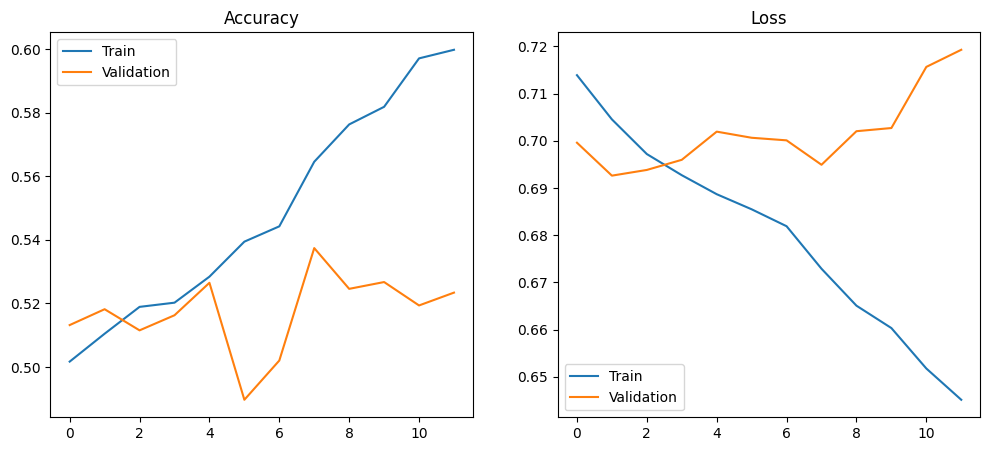

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_hy300.history['accuracy'], label='Train')
plt.plot(history_hy300.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_hy300.history['loss'], label='Train')
plt.plot(history_hy300.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

plt.show()

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = (model_hyb300.predict(X_test_win) > 0.5).astype(int)

print(confusion_matrix(y_test_win, y_pred))
print(classification_report(y_test_win, y_pred))

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[1608 1020]
 [1494  972]]
              precision    recall  f1-score   support

           0       0.52      0.61      0.56      2628
           1       0.49      0.39      0.44      2466

    accuracy                           0.51      5094
   macro avg       0.50      0.50      0.50      5094
weighted avg       0.50      0.51      0.50      5094



In [57]:
#find optimal threshold using 

val_seg_preds = model_hyb300.predict(X_val_win).flatten()

df_val = pd.DataFrame({
    "worm_id": worm_val_win,
    "y_true": y_val_win,
    "y_pred": val_seg_preds
})

worm_val = df_val.groupby("worm_id").agg({
    "y_true": "first",
    "y_pred": "mean"
}).reset_index()

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(worm_val["y_true"], worm_val["y_pred"])

J = tpr - fpr
ix = J.argmax()

optimal_threshold = thresholds[ix]

print("Optimal threshold:", optimal_threshold)
print("TPR:", tpr[ix], "FPR:", fpr[ix])

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Optimal threshold: 0.49684983
TPR: 0.6666666666666666 FPR: 0.0


In [58]:
#aggregate back to segment then back to worm

win_preds = model_hyb300.predict(X_test_win).flatten()


df_win = pd.DataFrame({
    "segment_id": seg_test_win,
    "worm_id": worm_test_win,
    "y_true": y_test_win,
    "y_pred": win_preds
})

seg_level = df_win.groupby("segment_id").agg({
    "worm_id": "first",
    "y_true": "first",
    "y_pred": "mean"   # average window prediction
}).reset_index()

# convert to hard labels
seg_level["y_pred_label"] = (seg_level["y_pred"] > 0.5).astype(int)

worm_level = seg_level.groupby("worm_id").agg({
    "y_true": "first",
    "y_pred": "mean"
}).reset_index()

worm_level["y_pred_label"] = (worm_level["y_pred"] > optimal_threshold).astype(int)

from sklearn.metrics import accuracy_score, classification_report

print("Worm-level accuracy:", accuracy_score(worm_level["y_true"], worm_level["y_pred_label"]))
print(classification_report(worm_level["y_true"], worm_level["y_pred_label"]))

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Worm-level accuracy: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.55      0.60      0.57        10

    accuracy                           0.57        21
   macro avg       0.57      0.57      0.57        21
weighted avg       0.57      0.57      0.57        21



In [19]:
# train model
history_hy900 = model_hyb900.fit(
    X_seg_train,
    y_seg_train,
    validation_data=(X_seg_val, y_seg_val), 
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.5013 - loss: 0.7228 - val_accuracy: 0.4547 - val_loss: 0.7034 - learning_rate: 0.0010
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5112 - loss: 0.7102 - val_accuracy: 0.4711 - val_loss: 0.7044 - learning_rate: 0.0010
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5144 - loss: 0.7068 - val_accuracy: 0.5118 - val_loss: 0.6965 - learning_rate: 0.0010
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5047 - loss: 0.7039 - val_accuracy: 0.5289 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.5255 - loss: 0.6962 - val_accuracy: 0.5025 - val_loss: 0.7018 - learning_rate: 0.0010
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5460 - loss: 0.6870 - val_accuracy: 0.5367 - val_loss: 0.6958 - learning_rate: 3.0000e-04
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.563

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = (model_hyb900.predict(X_seg_test) > 0.461).astype(int)

print(confusion_matrix(y_seg_test, y_pred))
print(classification_report(y_seg_test, y_pred))

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[341 535]
 [308 514]]
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       876
           1       0.49      0.63      0.55       822

    accuracy                           0.50      1698
   macro avg       0.51      0.51      0.50      1698
weighted avg       0.51      0.50      0.50      1698



In [51]:
#find optimal threshold using 

val_seg_preds = model_hyb900.predict(X_seg_val).flatten()

df_val = pd.DataFrame({
    "worm_id": worm_ids_val,
    "y_true": y_seg_val,
    "y_pred": val_seg_preds
})

worm_val = df_val.groupby("worm_id").agg({
    "y_true": "first",
    "y_pred": "mean"
}).reset_index()

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(worm_val["y_true"], worm_val["y_pred"])

J = tpr - fpr
ix = J.argmax()

optimal_threshold = thresholds[ix]

print("Optimal threshold:", optimal_threshold)
print("TPR:", tpr[ix], "FPR:", fpr[ix])



44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Optimal threshold: 0.46352357
TPR: 0.4444444444444444 FPR: 0.25


In [55]:
segment_preds = model_hyb900.predict(X_seg_test).flatten()

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Build a DataFrame linking each segment to its worm and predictions
df_pred = pd.DataFrame({
    "worm_id": worm_ids_test,     # array of worm IDs for test segments
    "y_true": y_seg_test,       # true labels for test segments
    "y_pred": segment_preds       # predicted probabilities from model
})

# ---- SOFT VOTING (probability averaging per worm) ----
worm_level = df_pred.groupby("worm_id").agg({
    "y_true": "first",       # all segments of a worm share same label
    "y_pred": "mean"         # average probability = soft vote
}).reset_index()

# Convert averaged probabilities to labels
worm_level["y_pred_label"] = (worm_level["y_pred"] > 0.463).astype(int)

# ---- Evaluate worm-level accuracy ----
print("Worm-level accuracy:", accuracy_score(worm_level["y_true"], worm_level["y_pred_label"]))
print(classification_report(worm_level["y_true"], worm_level["y_pred_label"]))


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Worm-level accuracy: 0.47619047619047616
              precision    recall  f1-score   support

           0       0.50      0.64      0.56        11
           1       0.43      0.30      0.35        10

    accuracy                           0.48        21
   macro avg       0.46      0.47      0.46        21
weighted avg       0.47      0.48      0.46        21

